In [27]:
import pandas as pd

datSet = pd.read_csv('../data/play_tennis.csv')
datSet.head()

,day,outlook,temp,humidity,wind,play
0,D1,Sunny,Hot,High,Weak,No
1,D2,Sunny,Hot,High,Strong,No
2,D3,Overcast,Hot,High,Weak,Yes
3,D4,Rain,Mild,High,Weak,Yes
4,D5,Rain,Cool,Normal,Weak,Yes


In [28]:
from Decision_Trees.models.utils import cleanData

ogDatSet = datSet.drop(columns=["day"])
datSet = cleanData(datSet)
datSet.head()

,outlook,temp,humidity,wind,play
0,2,1,0,1,0
1,2,1,0,0,0
2,0,1,0,1,1
3,1,2,0,1,1
4,1,0,1,1,1


In [33]:
def get_mappings(original_df, encoded_df):
    mappings = {}
    for col in original_df.columns:
        mappings[col] = dict(enumerate(original_df[col].astype("category").cat.categories))
    mappings["target_col"] = original_df.columns[-1]
    return mappings

In [34]:
mappings = get_mappings(ogDatSet, datSet)
mappings

{'outlook': {0: 'Overcast', 1: 'Rain', 2: 'Sunny'},
 'temp': {0: 'Cool', 1: 'Hot', 2: 'Mild'},
 'humidity': {0: 'High', 1: 'Normal'},
 'wind': {0: 'Strong', 1: 'Weak'},
 'play': {0: 'No', 1: 'Yes'},
 'target_col': 'play'}

In [35]:
from Decision_Trees.models.utils import getFeatLabel

X, y = getFeatLabel(datSet)

In [36]:
X

,outlook,temp,humidity,wind
0,2,1,0,1
1,2,1,0,0
2,0,1,0,1
3,1,2,0,1
4,1,0,1,1
5,1,0,1,0
6,0,0,1,0
7,2,2,0,1
8,2,0,1,1
9,1,2,1,1


In [37]:
y

0     0
1     0
2     1
3     1
4     1
5     0
6     1
7     0
8     1
9     1
10    1
11    1
12    1
13    0
Name: play, dtype: int8

In [38]:
from Decision_Trees.models.utils import buildTree

tree = buildTree(X, y, max_depth=3)

In [39]:
print(tree.feat)

0


In [40]:
def get_mapped_value(feature, encoded_value, mappings):
    if feature == 'label':
        feature = mappings['target_col']
    return mappings[feature].get(encoded_value, encoded_value)

def get_edge_label(feature, branch_idx, mappings):
    if mappings and feature in mappings:
        return list(mappings[feature].values())[branch_idx]
    return str(branch_idx)

In [41]:
from graphviz import Digraph
import re

def sanitize_name(name):
    """Convert strings to valid DOT identifiers"""
    return re.sub(r'[^a-zA-Z0-9_]', '_', str(name))

def visualize_tree_graphviz(node, X, mappings=None, graph=None, parent=None, edge_label=None):
    if graph is None:
        graph = Digraph(format='png', engine='dot')
        graph.attr('node', shape='box', style='rounded')

    # Create safe node names
    if node.label is not None:
        node_name = f"leaf_{sanitize_name(node.label)}"
        label_text = f"Class: {get_mapped_value('label', node.label, mappings)}"
        graph.node(node_name, label=label_text, shape='ellipse', style='filled', fillcolor='lightgreen')
    else:
        feature_name = X.columns[node.feat]
        node_name = f"split_{sanitize_name(feature_name)}"
        label_text = f"Split on {feature_name}"
        graph.node(node_name, label=label_text, shape='diamond', fillcolor='lightblue', style='filled')

    if parent is not None:
        graph.edge(parent, node_name, label=edge_label or "")

    if hasattr(node, 'children') and node.children:
        for i, child in enumerate(node.children):
            feature_name = X.columns[node.feat]
            edge_lbl = get_edge_label(feature_name, i, mappings)
            visualize_tree_graphviz(child, X, mappings, graph, node_name, edge_lbl)

    return graph

def draw_tree_graphviz(tree, X, mappings=None, filename='decision_tree'):
    graph = visualize_tree_graphviz(tree, X, mappings)
    graph.attr(size='10,10', rankdir='TB')
    graph.render(filename, view=True, cleanup=True)
    return graph

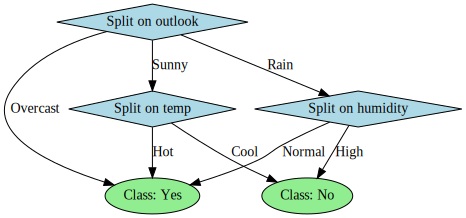

In [42]:
from Decision_Trees.models.utils import predict

# Visualize the tree
graph = draw_tree_graphviz(tree, X, mappings, filename='tennis_decision_tree')
graph

In [43]:
# Make a prediction
sample = X.iloc[0]  # Example sample
prediction = predict(tree, sample)
print(f"Predicted class: {get_mapped_value('play', prediction, mappings)}")

Predicted class: Yes
